Model loaded and recompiled.
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
📊 RMSE: 110.47
📊 MAE : 89.59


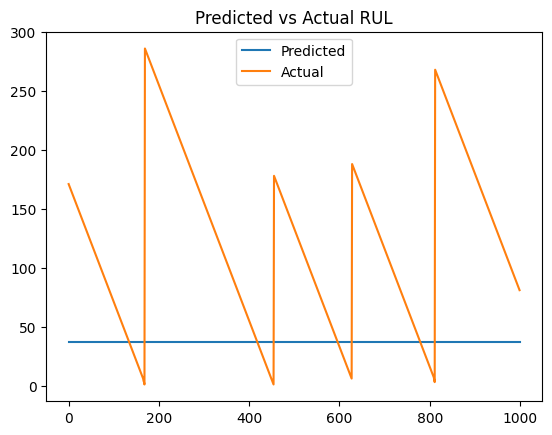

In [4]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assume X_clean is available from training (same 17 features)
# If not, load and prepare it the same way you did during training.

# -----------------------
# 1. RELOAD TRAINING DATA IF NECESSARY
# -----------------------
import pandas as pd

# Load NASA training data
df_train = pd.read_csv("/content/sample_data/train_FD001.txt", sep="\s+", header=None)
df_train.dropna(axis=1, how='all', inplace=True)
column_names = [
    'unit_number', 'time_in_cycles',
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
    'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
    'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
    'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'
]
df_train.columns = column_names

# Calculate RUL
rul = df_train.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul.columns = ['unit_number', 'max_cycle']
df_train = df_train.merge(rul, on='unit_number')
df_train['RUL'] = df_train['max_cycle'] - df_train['time_in_cycles']
df_train.drop('max_cycle', axis=1, inplace=True)

# Select the same training features
train_features = [
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7',
    'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12',
    'sensor_13', 'sensor_14', 'sensor_15',
    'sensor_17', 'sensor_20', 'sensor_21'
]

# Clean and normalize
from sklearn.ensemble import IsolationForest

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_train[train_features])
iso = IsolationForest(contamination=0.01)
clean_mask = iso.fit_predict(X_scaled) == 1
X_clean = X_scaled[clean_mask]
y_clean = df_train['RUL'][clean_mask].values

# -----------------------
# 2. CREATE TEST SEQUENCES
# -----------------------
def create_sequences(data, labels, seq_length=20):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(labels[i+seq_length])
    return np.array(xs), np.array(ys)

X_test_seq, y_test_seq = create_sequences(X_clean[:1020], y_clean[:1020], seq_length=20)

# -----------------------
# 3. LOAD MODEL
# -----------------------
model = load_model("/content/sample_data/predictive_maintenance_lstm_model.h5", compile=False)
model.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
print("Model loaded and recompiled.")

# -----------------------
# 4. PREDICT
# -----------------------
y_pred = model.predict(X_test_seq)

# -----------------------
# 5. EVALUATE
# -----------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
mae = mean_absolute_error(y_test_seq, y_pred)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAE : {mae:.2f}")

# Plot
plt.plot(y_pred, label='Predicted')
plt.plot(y_test_seq, label='Actual')
plt.legend()
plt.title("Predicted vs Actual RUL")
plt.show()
